In [3]:
import pandas as pd
import numpy as np
import datetime
from matplotlib import pyplot as plt
import collections
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, log_loss, roc_auc_score,make_scorer, classification_report, confusion_matrix
from time import time
from sklearn.pipeline import Pipeline
import seaborn as sns
import itertools
from sklearn.decomposition import PCA

In [4]:
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=DeprecationWarning)

In [34]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [6]:
#Загружаем данные по 4 турнирам
england = pd.read_csv('England 18-21.csv')
germany = pd.read_csv('Germany 18-21.csv')
italy = pd.read_csv('Italy 18-21.csv')
spain = pd.read_csv('Spain 18-21.csv')
data = pd.concat([england, germany, italy, spain], axis=0)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5976 entries, 0 to 1579
Columns: 469 entries, id to Передачи точные соперника
dtypes: float64(456), int64(8), object(5)
memory usage: 21.4+ MB


In [7]:
data.head()

,id,tournament,id.1,tour,match_date,c_team1_id,c_team2_id,team1,team2,score_team1,score_team2,team_id,team_name,Голы пропущенные (счет в матче),Голы забитые (счет в матче),"Владение мячом более 45 сек, количе","Владение мячом от 15 до 45 сек, колич","Владение мячом от 5 до 15 сек, количе","Владение мячом менее 5 сек, количес","Владение мячом, средняя длительно","Владение мячом, количество",Единоборства вверху выигранные в,Единоборства внизу выигранные в о,Единоборства вверху выигранные в.1,Единоборства внизу выигранные в а,Единоборства вверху в обороне,Единоборства внизу в обороне,Единоборства вверху в атаке,Единоборства внизу в атаке,"Владение мячом соперника, сек","Владение мячом, сек","Владение мячом, %",Передачи точные,Передачи,ТТД,Единоборства удачные,Передачи конструктивные,Фолы,Передачи подготовительные,Единоборства вверху удачные,...,"Подачи с углового с ударами, %",Подачи с углового с голами,"Подачи с углового с голами, %",Перехват передачи неудачный,Блокировка удара неудачная,Индекс оборонительных действий (ф,Индекс атакующих действий (футзал),Ключевые перехваты в обороне,Голы пропущенные при атаках с пена,Голы забитые (счет в матче с учётом,Голы пропущенные (счет в матче с уч,Свободные удары от ворот,Голы головой,Голы правой ногой,Голы левой ногой,Голы телом,% голов головой,% голов правой ногой,% голов левой ногой,% голов телом,Вратарь - % отбитых ударов в створ,ЖК (с учётом КК за вторую ЖК),xG сумма,xG среднее,true xG,Передачи в одно касание.1,Передачи в одно касание точные.1,"Передачи в одно касание точные, %",Передачи диагональные.1,Передачи диагональные точные,"Передачи диагональные точные, %",PPDA,xGA,xGTD,xGAPS,xGPG,xGAPG,xPoints,xGC,Передачи точные соперника
0,39,England. Premier League,1171024,1,2018-08-10 22:00:00,21,1020,Manchester United,Leicester City,2,1,21,Manchester United,1.0,2.0,10.0,20.0,40.0,26.0,16.71,96.0,11.0,26.0,5.0,8.0,18.0,51.0,13.0,21.0,1828.0,1604.0,46.74,420.0,497.0,847.0,34.0,356.0,11.0,124.0,16.0,...,0.00,NaN,0.00,NaN,NaN,170.0,84.0,3.0,1.0,2.0,1.0,5.0,NaN,1.0,1.0,NaN,0.0,50.0,50.0,0.0,75.00,2.0,1.54,0.17,1.53,165.0,132.0,80.00,7.0,7.0,100.0,4.61,1.81,-0.27,0.12,0.77,1.81,0.7,1.30,484.0
1,39,England. Premier League,1171024,1,2018-08-10 22:00:00,21,1020,Manchester United,Leicester City,2,1,1020,Leicester City,2.0,1.0,10.0,29.0,44.0,22.0,17.41,105.0,8.0,13.0,7.0,25.0,13.0,21.0,18.0,51.0,1604.0,1828.0,53.26,484.0,567.0,937.0,38.0,411.0,8.0,143.0,15.0,...,40.00,NaN,0.00,NaN,NaN,158.0,110.9,3.0,NaN,1.0,2.0,1.0,1.0,NaN,NaN,NaN,100.0,0.0,0.0,0.0,66.67,1.0,1.81,0.12,1.79,163.0,137.0,84.05,11.0,11.0,100.0,7.37,1.54,0.27,0.17,1.81,0.77,1.5,0.55,420.0
2,39,England. Premier League,1171025,1,2018-08-11 14:30:00,249,67,Newcastle United,Tottenham Hotspur,1,2,249,Newcastle United,2.0,1.0,2.0,27.0,56.0,37.0,11.30,122.0,13.0,11.0,21.0,18.0,21.0,21.0,41.0,30.0,1835.0,1379.0,42.91,325.0,428.0,821.0,29.0,300.0,11.0,115.0,34.0,...,66.67,NaN,0.00,NaN,NaN,178.0,116.2,2.0,NaN,1.0,2.0,5.0,1.0,NaN,NaN,NaN,100.0,0.0,0.0,0.0,66.67,2.0,1.22,0.09,1.22,155.0,108.0,69.68,5.0,5.0,100.0,8.16,2.58,-1.36,0.18,1.22,1.29,0.3,0.82,522.0
3,39,England. Premier League,1171025,1,2018-08-11 14:30:00,249,67,Newcastle United,Tottenham Hotspur,1,2,67,Tottenham Hotspur,1.0,2.0,3.0,41.0,40.0,36.0,15.29,120.0,20.0,12.0,8.0,10.0,41.0,30.0,21.0,21.0,1379.0,1835.0,57.09,522.0,616.0,1032.0,22.0,405.0,11.0,195.0,28.0,...,50.00,1.0,16.67,NaN,NaN,198.0,109.6,2.0,NaN,2.0,1.0,6.0,2.0,NaN,NaN,NaN,100.0,0.0,0.0,0.0,66.67,2.0,2.58,0.18,2.58,188.0,143.0,76.06,8.0,6.0,75.0,3.25,1.22,1.36,0.09,1.29,1.22,2.3,0.78,325.0
4,39,England. Premier League,1171019,1,2018-08-11 17:00:00,1588,1012,AFC Bournemouth,Cardiff City,2,0,1588,AFC Bournemouth,NaN,2.0,11.0,26.0,41.0,33.0,15.59,111.0,28.0,8.0,8.0,19.0,54.0,27.0,21.0,36.0,1212.0,1731.0,58.82,451.0,544.0,942.0,27.0,354.0,11.0,173.0,36.0,...,14.29,NaN,0.00,NaN,NaN,137.0,99.9,1.0,NaN,2.0,NaN,5.0,NaN,2.0,NaN,NaN,0.0,100.0,0.0,0.0,NaN,1.0,2.13,0.21,2.13,167.0,117.0,70.06,NaN,NaN,NaN,2.75,0.74,1.39,0.11,1.07,NaN,

In [8]:
#Определяем команды, сыгравшие хотя бы один полный сезон
all_teams = data.groupby('team_id').count()['id.1']

all_teams = all_teams.where(lambda x: x>=10).dropna()
teams = all_teams.index.tolist()
print(teams)

#Удаляем строки с прочими командами
data = data[(data['c_team1_id'].isin(teams))&(data['c_team2_id'].isin(teams))]
data = data.reset_index(drop=True)

[20, 21, 38, 52, 55, 56, 63, 67, 70, 71, 84, 131, 134, 151, 152, 183, 226, 228, 242, 246, 247, 248, 249, 253, 255, 256, 257, 258, 260, 262, 263, 265, 266, 267, 270, 271, 272, 275, 276, 277, 278, 279, 280, 281, 283, 284, 301, 302, 303, 304, 305, 306, 309, 310, 311, 312, 548, 549, 592, 593, 598, 649, 666, 688, 690, 693, 703, 708, 710, 720, 721, 1011, 1012, 1014, 1020, 1026, 1027, 1060, 1078, 1079, 1084, 1091, 1237, 1239, 1271, 1578, 1588, 2102, 4464, 6324]


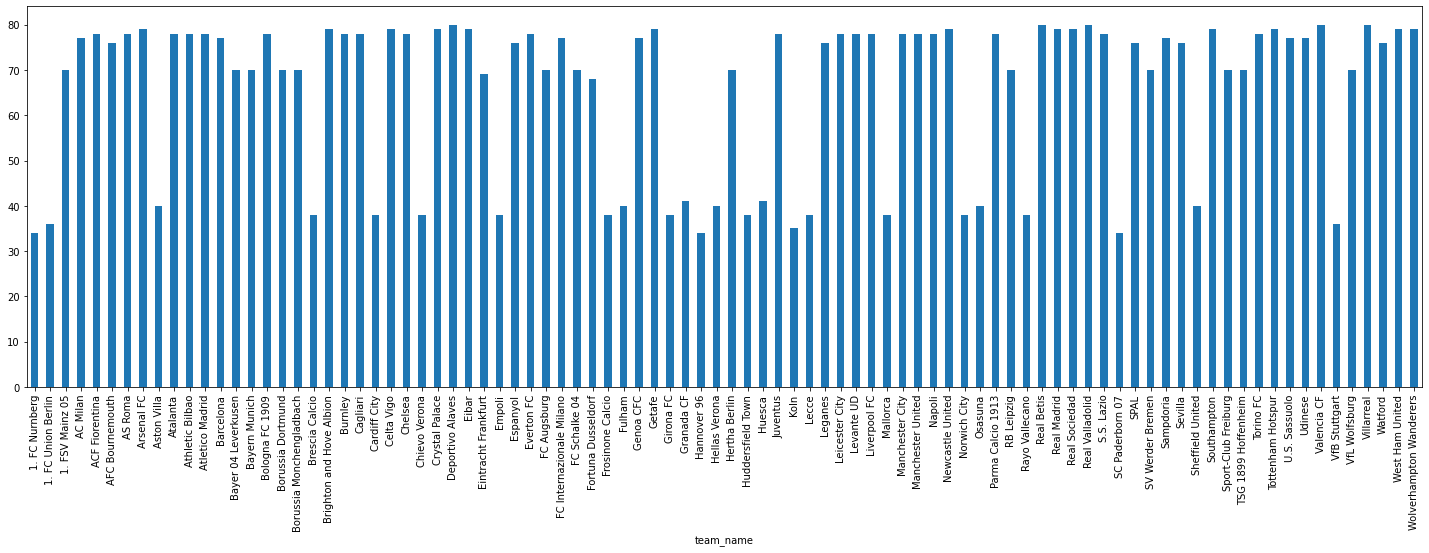

In [9]:
#Посмотрим число игр, сыгранных каждой из оставшихся команд
data.groupby('team_name').agg('count')['id.1'].plot(kind='bar', figsize=(25, 7))

In [10]:
#Создаем колонку с результатом матча
def result(df):
    if ((df['team_id'] == df['c_team1_id']) and (df['score_team1'] > df['score_team2'])) or ((df['team_id'] == df['c_team2_id']) and (df['score_team1'] < df['score_team2'])):
        return 'win'
    elif ((df['team_id'] == df['c_team1_id']) and (df['score_team1'] < df['score_team2'])) or ((df['team_id'] == df['c_team2_id']) and (df['score_team1'] > df['score_team2'])):
        return 'defeat'
    elif ((df['team_id'] == df['c_team1_id']) and (df['score_team1'] == df['score_team2'])) or ((df['team_id'] == df['c_team2_id']) and (df['score_team1'] == df['score_team2'])):
        return 'draw'
    
data['result'] = data.apply(result, axis=1)

In [11]:
data['match_date'] = pd.to_datetime(data['match_date'])
#Пишем функцию, возвращающую номер сезона
def season(x):
    if ((x>=datetime.datetime.strptime("01-08-2017", "%d-%m-%Y"))&(x<=datetime.datetime.strptime("01-07-2018", "%d-%m-%Y"))):
        return 17
    elif ((x>=datetime.datetime.strptime("01-08-2018", "%d-%m-%Y"))&(x<=datetime.datetime.strptime("01-07-2019", "%d-%m-%Y"))):
        return 19
    elif ((x>=datetime.datetime.strptime("01-08-2019", "%d-%m-%Y"))&(x<=datetime.datetime.strptime("01-08-2020", "%d-%m-%Y"))):
        return 21
    elif ((x>=datetime.datetime.strptime("01-08-2020", "%d-%m-%Y"))&(x<=datetime.datetime.strptime("01-07-2021", "%d-%m-%Y"))):
        return 23
            
data['season'] = data['match_date'].apply(season)

In [12]:
#Создаем колонку с определение того, где играла команда(дома/в гостях)
data['home/away']=data.apply(lambda df:1 if df['team_id']==df['c_team1_id'] else 0, axis=1)

#Создаем колонку с именем команды-проигравшей
data['opponent_team_name'] = data.apply(lambda df: df['team2'] if df['team_name'] == df['team1'] else df['team1'], axis=1)

Обрабатываем пропущенные значения

In [13]:
#Где пропущены удары и xG - там их число равно 0
data['Удары'].fillna(0, inplace=True)   
#data['Удары в створ'].fillna(0, inplace=True)
data['xG сумма'].fillna(0, inplace=True)
#data['Единоборства всего выигранные'].fillna(0, inplace=True)
#data['Передачи конструктивные'].fillna(0, inplace=True)
#data['Перехваты передач'].fillna(0, inplace=True)
#data['xG сумма'].fillna(0, inplace=True)
data = data[data['Скорость точных передач'].notna()]
data = data[data['Владение мячом, сек'].notna()]
data['Единоборства всего выигранные'].fillna(data['Единоборства всего выигранные'].mean(), inplace=True)
data['Навесы и прострелы'].fillna(data['Навесы и прострелы'].mean(), inplace=True)
data['PPDA'].fillna(data['PPDA'].mean(), inplace=True)
#data['Обостряющие передачи'].fillna(0, inplace=True)

#Преобразуем категориальные значения - названия турниров
tournament_dummies = pd.get_dummies(data['tournament'], prefix='tournament')
data = pd.concat([data, tournament_dummies], axis=1)
data.drop('tournament', axis=1, inplace=True)

In [14]:
#Отбор признаков
columns = ['id.1','team_id', 'c_team1_id', 'c_team2_id', 'team1', 'team2', 'team_name','opponent_team_name','season','tour','match_date',
           'result','Удары','Единоборства всего выигранные','PPDA',
           'Передачи конструктивные','Перехваты передач', 'xG сумма','home/away','Средний InStatIndex',
           'Владение мячом, сек','Отборы','Обводки','Подборы',
           'Скорость атакующих действий в мин','Скорость точных передач','Навесы и прострелы',
           'Передачи на чужой половине поля','Обостряющие и острые передачи',
           'tournament_England. Premier League', 'tournament_Germany. Bundesliga','tournament_Italy. Serie A','tournament_Spain. Primera Division']

columns_need = ['Удары','Единоборства всего выигранные','PPDA',
           'Передачи конструктивные','Перехваты передач', 'xG сумма','Средний InStatIndex',
           'Владение мячом, сек','Отборы','Обводки','Подборы',
           'Скорость атакующих действий в мин','Скорость точных передач','Навесы и прострелы',
           'Передачи на чужой половине поля','Обостряющие и острые передачи']

extra_columns =['home/away','tournament_England. Premier League', 'tournament_Germany. Bundesliga','tournament_Italy. Serie A','tournament_Spain. Primera Division']

columns_no_need = [column for column in columns if ((column not in columns_need)&(column not in extra_columns))]

In [15]:
number_of_matches = 10
#Получаем аггрегированные(суммарные) статистические данные каждой команды за последние 10 матчей от текущего
def get_last_matches(data, date, team, x = number_of_matches):
    team_matches = data[(data['team_name'] == team)&(data['match_date']<date)].sort_values(by=['match_date'], ascending=False).iloc[0:x]
    team_matches = team_matches.loc[:, columns_need] #Оставляем только нужные столбцы
    team_matches_group = team_matches.sum().values.tolist()
    return team_matches_group


#Для каждого матча считаем вектор, равный разнице суммарных показателей соперников за последние 10 матчей
def match_difference(data, match_id, team, opponent):
    date_x = data['match_date'][data['id.1'] == match_id].iloc[0]
    diff = [x - y for x, y in zip(get_last_matches(data, date_x, team), get_last_matches(data, date_x, opponent))]
    return diff

In [16]:
#Для всего датафрейма считаем вектора разностей показателей команд по всем матчам
def get_all_differences(data):
    df = pd.DataFrame(columns=columns)

    for index, row in data.iterrows():
        df.loc[index, columns_need] = match_difference(data, row['id.1'], row['team_name'], row['opponent_team_name'])
        df.loc[index, extra_columns] = row[extra_columns]
        df.loc[index, columns_no_need] = row[columns_no_need]
    return df

In [17]:
saved_data = data.copy()
data = get_all_differences(data)
#Отсекаем столько матчей вначале, для которых не найдется предыдущих 10 сыгранных каждой командой
data = data.assign(team_matches_count = data.groupby('team_name')['id.1'].cumcount()+1)
data = data.assign(opponent_team_matches_count = data.groupby('opponent_team_name')['id.1'].cumcount()+1)
data = data[(data['team_matches_count']>=number_of_matches)&(data['opponent_team_matches_count']>=number_of_matches)]
data = data.reset_index(drop=True)

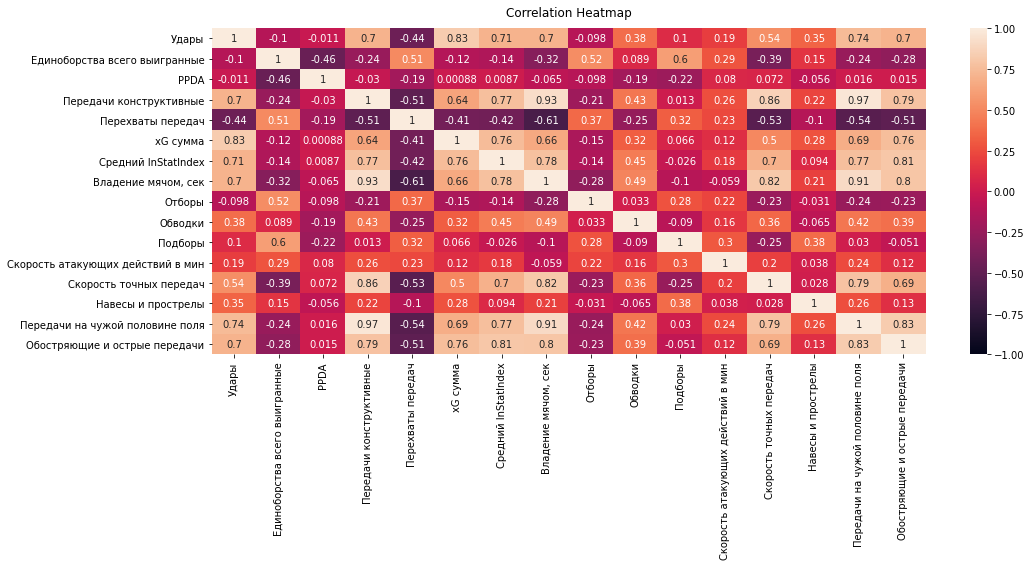

In [18]:
#Масштабируем признаки
data.loc[:, columns_need] = StandardScaler().fit_transform(data.loc[:, columns_need])

#Посмотрим на корреляцию между признаками
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(data.loc[:, columns_need].corr(), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

In [19]:
features_columns = columns_need + extra_columns

labels = data.loc[:, 'result']   #Целевая переменная
features = data.loc[:, features_columns]    #Признаки
features = features.apply(pd.to_numeric, errors='coerce')
features

,Удары,Единоборства всего выигранные,PPDA,Передачи конструктивные,Перехваты передач,xG сумма,Средний InStatIndex,"Владение мячом, сек",Отборы,Обводки,Подборы,Скорость атакующих действий в мин,Скорость точных передач,Навесы и прострелы,Передачи на чужой половине поля,Обостряющие и острые передачи,home/away,tournament_England. Premier League,tournament_Germany. Bundesliga,tournament_Italy. Serie A,tournament_Spain. Primera Division
0,-0.460724,-0.076144,0.286343,0.071317,0.480614,-0.321680,-0.031514,-0.099272,0.997518,0.352649,0.027482,0.408755,0.220998,-0.422703,-0.172343,-0.017594,1,1,0,0,0
1,0.461242,0.077538,-0.287285,-0.071616,-0.480729,0.321919,0.031275,0.099025,-0.996939,-0.351851,-0.026872,-0.408525,-0.221384,0.423702,0.172139,0.017461,0,1,0,0,0
2,-0.091938,0.058328,0.177833,-0.006646,-0.000058,0.054377,-0.019549,-0.091226,-0.366039,0.282199,-0.352992,0.192416,-0.004696,-0.305147,-0.094901,-0.035122,1,1,0,0,0
3,0.092455,-0.056934,-0.178775,0.006347,-0.000058,-0.054137,0.019310,0.090978,0.366618,-0.281401,0.353602,-0.192186,0.004310,0.306146,0.094698,0.034989,0,1,0,0,0
4,0.860761,-1.065473,0.404726,0.993881,-2.691817,0.378047,0.590000,1.167816,-0.630610,0.916250,-1.290588,-0.527823,1.100135,0.447214,0.946557,0.858793,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4984,0.000259,3.083946,-1.433061,-0.048227,1.906605,-0.381550,-0.446922,-0.692108,1.913340,-0.880227,2.609267,1.407654,-1.039735,0.940950,0.246911,-0.893982,0,0,0,0,1
4985,-1.013904,1.883304,-1.609462,-0.144381,1.201621,-0.093427,-0.084871,-0.533212,0.671892,-1.954590,3.356626,0.119413,-0.605233,0.141567,-0.158991,0.403071,1,0,0,0,1
4986,1.014422,-1.881910,1.608519,0.144082,-1.201736,0.093666,0.084632,0.532964,-0.671313,1.955388,-3.356016,-0.119183,0.604846,-0.140568,0.158787,-0.403205,0,0,0,0,1
4987,1.321744,1.182129,-0.844167,0.719710,-0.320505,0.828941,0.958578,0.490434,1.078924,0.704900,0.951489,0.659815,0.671823,0.141567,0.738265,-0.140289,1,0,0,0,1


In [20]:
#Посмотрим на корреляцию между каждым из признаков и целевой переменной
new_df = pd.concat([features, labels], axis=1)
def result1(df):
    if df['result']=='draw':
        return 2
    elif df['result']=='defeat':
        return 1
    elif df['result']=='win':
        return 3
    
new_df['result'] = new_df.apply(result1, axis=1)
new_df.corrwith(new_df['result'])

Удары                                 0.283741
Единоборства всего выигранные        -0.077820
PPDA                                  0.032077
Передачи конструктивные               0.325321
Перехваты передач                    -0.188183
xG сумма                              0.306284
Средний InStatIndex                   0.363966
Владение мячом, сек                   0.317627
Отборы                               -0.090370
Обводки                               0.122145
Подборы                               0.015878
Скорость атакующих действий в мин     0.053604
Скорость точных передач               0.261581
Навесы и прострелы                    0.070232
Передачи на чужой половине поля       0.345464
Обостряющие и острые передачи         0.355964
home/away                             0.158850
tournament_England. Premier League   -0.000247
tournament_Germany. Bundesliga        0.000237
tournament_Italy. Serie A            -0.000249
tournament_Spain. Primera Division    0.000277
result       

Обучение моделей и оценка их точности

In [21]:
def compute_score(clf, X, y, scoring='accuracy'):
    xval = cross_val_score(clf, X, y, cv = 3, scoring=scoring)
    return np.mean(xval)

In [22]:
#Функция поиска лучшего набора параметров в каждом из классификаторов
def find_best_classifier(classifiers, X, y, params):
    
    best_pipes_dict = {}
    best_params_dict = {}
    best_scores_dict = {}
    cross_validation = StratifiedKFold(n_splits=5, random_state=1)

    for clf in clfs:
            
        estimators = [('dm_reduce', PCA()), ('clf', clf)]
        #estimators = [('clf', clf)]
        pipeline = Pipeline(estimators)
        #start = time()

        grid_search = GridSearchCV(pipeline,
                                       scoring='accuracy',
                                       param_grid=params[clf],
                                       cv=cross_validation,
                                       verbose=1,
                                       n_jobs=-1)        

        best_score = compute_score(grid_search, X, y)
        
        grid_search.fit(X, y)        
        
        print(clf.__class__.__name__)
        print('Best score: {:.4f}'.format(best_score))
        print('Best parameters: {}'.format(grid_search.best_params_))      
        #end = time()
        #print("Made predictions in {:.4f} minutes".format((end - start)/60))
        print(' ')

        best_pipes_dict[clf]=grid_search.best_estimator_
        best_params_dict[clf]=grid_search.best_params_
        best_scores_dict[clf]=best_score
         
    return best_pipes_dict, best_params_dict, best_scores_dict

In [73]:
#Функция построения матрицы ошибок
def plot_confusion_matrix(y, X, clf, cmap=plt.cm.Blues, normalize = False):
    
    labels = ["win", "draw", "defeat"]
    cm = confusion_matrix(y, clf.predict(X), labels)
    
    if normalize == True:
        
        cm = cm.astype('float') / cm.sum()
    
    #Configure figure
    sns.set_style("whitegrid", {"axes.grid" : False})
    fig = plt.figure(1)    
    plt.imshow(cm, interpolation='nearest', cmap = plt.cm.Blues)
    title= "Confusion matrix of a {}".format(clf.__class__.__name__)   
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, round(cm[i, j], 2),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    plt.show()
    
    #Print classification report
    y_pred = clf.predict(X)
    print(classification_report(y, y_pred)) 

In [24]:
RF_clf = RandomForestClassifier()
LOG_clf = LogisticRegressionCV()
KNN_clf =  KNeighborsClassifier()
SVM_clf = SVC()
GNB_clf = GaussianNB()
AB_clf = AdaBoostClassifier()

clfs = [RF_clf, LOG_clf, KNN_clf, SVM_clf, GNB_clf, AB_clf]
reducer = np.arange(10, features.shape[1], 3,dtype=int)


#scorer = make_scorer(accuracy_score)
parameters_RF = {'clf__n_estimators' : [80, 120],
                 'clf__max_depth' : [14, 18],
                 'clf__min_samples_split': [2, 3],
                 'clf__min_samples_leaf': [6, 8],
                 'clf__bootstrap': [True, False],
                 'dm_reduce__n_components': reducer,
                }

c_values = [1, 10, 30]
parameters_LOG = {'clf__Cs': c_values,
                     'clf__penalty': ['l2'],
                     'clf__solver' : ['liblinear', 'newton-cg', 'lbfgs'],
                     'dm_reduce__n_components': reducer,
                    }
'''{'clf__Cs': c_values,
                   'clf__penalty': ['l1'],
                   'clf__solver' : ['liblinear'],
                   'dm_reduce__n_components': reducer,
                  }'''


parameters_KNN = {'clf__n_neighbors': [10, 15, 20],
                  'clf__weights' : ['uniform', 'distance'],
                  'dm_reduce__n_components': reducer,
                 }

parameters_SVM = {'clf__C': [0.1, 1, 10], 
                  'clf__gamma': [0.001, 0.01, 1],
                  'dm_reduce__n_components': reducer,
                 }

parameters_GNB = {
                  'dm_reduce__n_components': reducer,
                 }

parameters_AB = {'clf__learning_rate': np.linspace(0.2, 1, 5),
                 'clf__n_estimators' : [20, 40, 60],
                 'dm_reduce__n_components': reducer,
                }

parameters = {clfs[0]: parameters_RF,
              clfs[1]: parameters_LOG,
              clfs[2]: parameters_KNN,
              clfs[3]: parameters_SVM,
              clfs[4]: parameters_GNB,
              clfs[5]: parameters_AB  
             }

In [36]:
#Возможность использовать поиск по сетке, либо лучшие параметры, подобранные этим поиском ранее
use_grid_search = False

if use_grid_search == True:
    best_pipes_dict, best_params_dict, best_scores_dict = find_best_classifier(clfs, features, labels, parameters)
else:
    for clf in clfs:
        print(clf.__class__.__name__)
        best_pipes_dict[clf].fit(features, labels)
        print("Score: {:.4f}.".format(compute_score(best_pipes_dict[clf], features, labels)))
        print(' ')

RandomForestClassifier
Score: 0.5067.
 
LogisticRegressionCV
Score: 0.5067.
 
KNeighborsClassifier
Score: 0.4742.
 
SVC
Score: 0.5133.
 
GaussianNB
Score: 0.5053.
 
AdaBoostClassifier
Score: 0.5115.
 


Лучшим получился классификатор SVC с результатом точности , равным 0.5133

In [27]:
for clf in clfs:
  print(clf.__class__.__name__, best_params_dict[clf])

RandomForestClassifier {'clf__bootstrap': True, 'clf__max_depth': 14, 'clf__min_samples_leaf': 8, 'clf__min_samples_split': 2, 'clf__n_estimators': 80, 'dm_reduce__n_components': 13}
LogisticRegressionCV {'clf__Cs': 10, 'clf__penalty': 'l2', 'clf__solver': 'newton-cg', 'dm_reduce__n_components': 13}
KNeighborsClassifier {'clf__n_neighbors': 15, 'clf__weights': 'distance', 'dm_reduce__n_components': 13}
SVC {'clf__C': 10, 'clf__gamma': 0.001, 'dm_reduce__n_components': 19}
GaussianNB {'dm_reduce__n_components': 13}
AdaBoostClassifier {'clf__learning_rate': 0.4, 'clf__n_estimators': 40, 'dm_reduce__n_components': 13}


Лучшие параметры классификаторов:

RandomForestClassifier {'clf__bootstrap': True, 'clf__max_depth': 14, 'clf__min_samples_leaf': 6, 'clf__min_samples_split': 3, 'clf__n_estimators': 120, 'dm_reduce__n_components': 13}

LogisticRegressionCV {'clf__Cs': 10, 'clf__penalty': 'l2', 'clf__solver': 'newton-cg', 'dm_reduce__n_components': 13}

KNeighborsClassifier {'clf__n_neighbors': 15, 'clf__weights': 'distance', 'dm_reduce__n_components': 13}

SVC {'clf__C': 10, 'clf__gamma': 0.001, 'dm_reduce__n_components': 19}

GaussianNB {'dm_reduce__n_components': 13}

AdaBoostClassifier {'clf__learning_rate': 0.4, 'clf__n_estimators': 40, 'dm_reduce__n_components': 13}

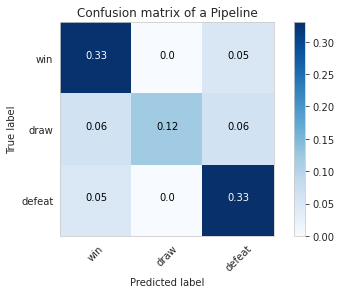

              precision    recall  f1-score   support

      defeat       0.74      0.88      0.80      1881
        draw       1.00      0.49      0.65      1229
         win       0.75      0.87      0.80      1879

    accuracy                           0.78      4989
   macro avg       0.83      0.74      0.75      4989
weighted avg       0.81      0.78      0.77      4989



In [75]:
#Строим матрицу ошибок для классификатора RandomForestClassifier
plot_confusion_matrix(labels, features, best_pipes_dict[clfs[0]], normalize = True)

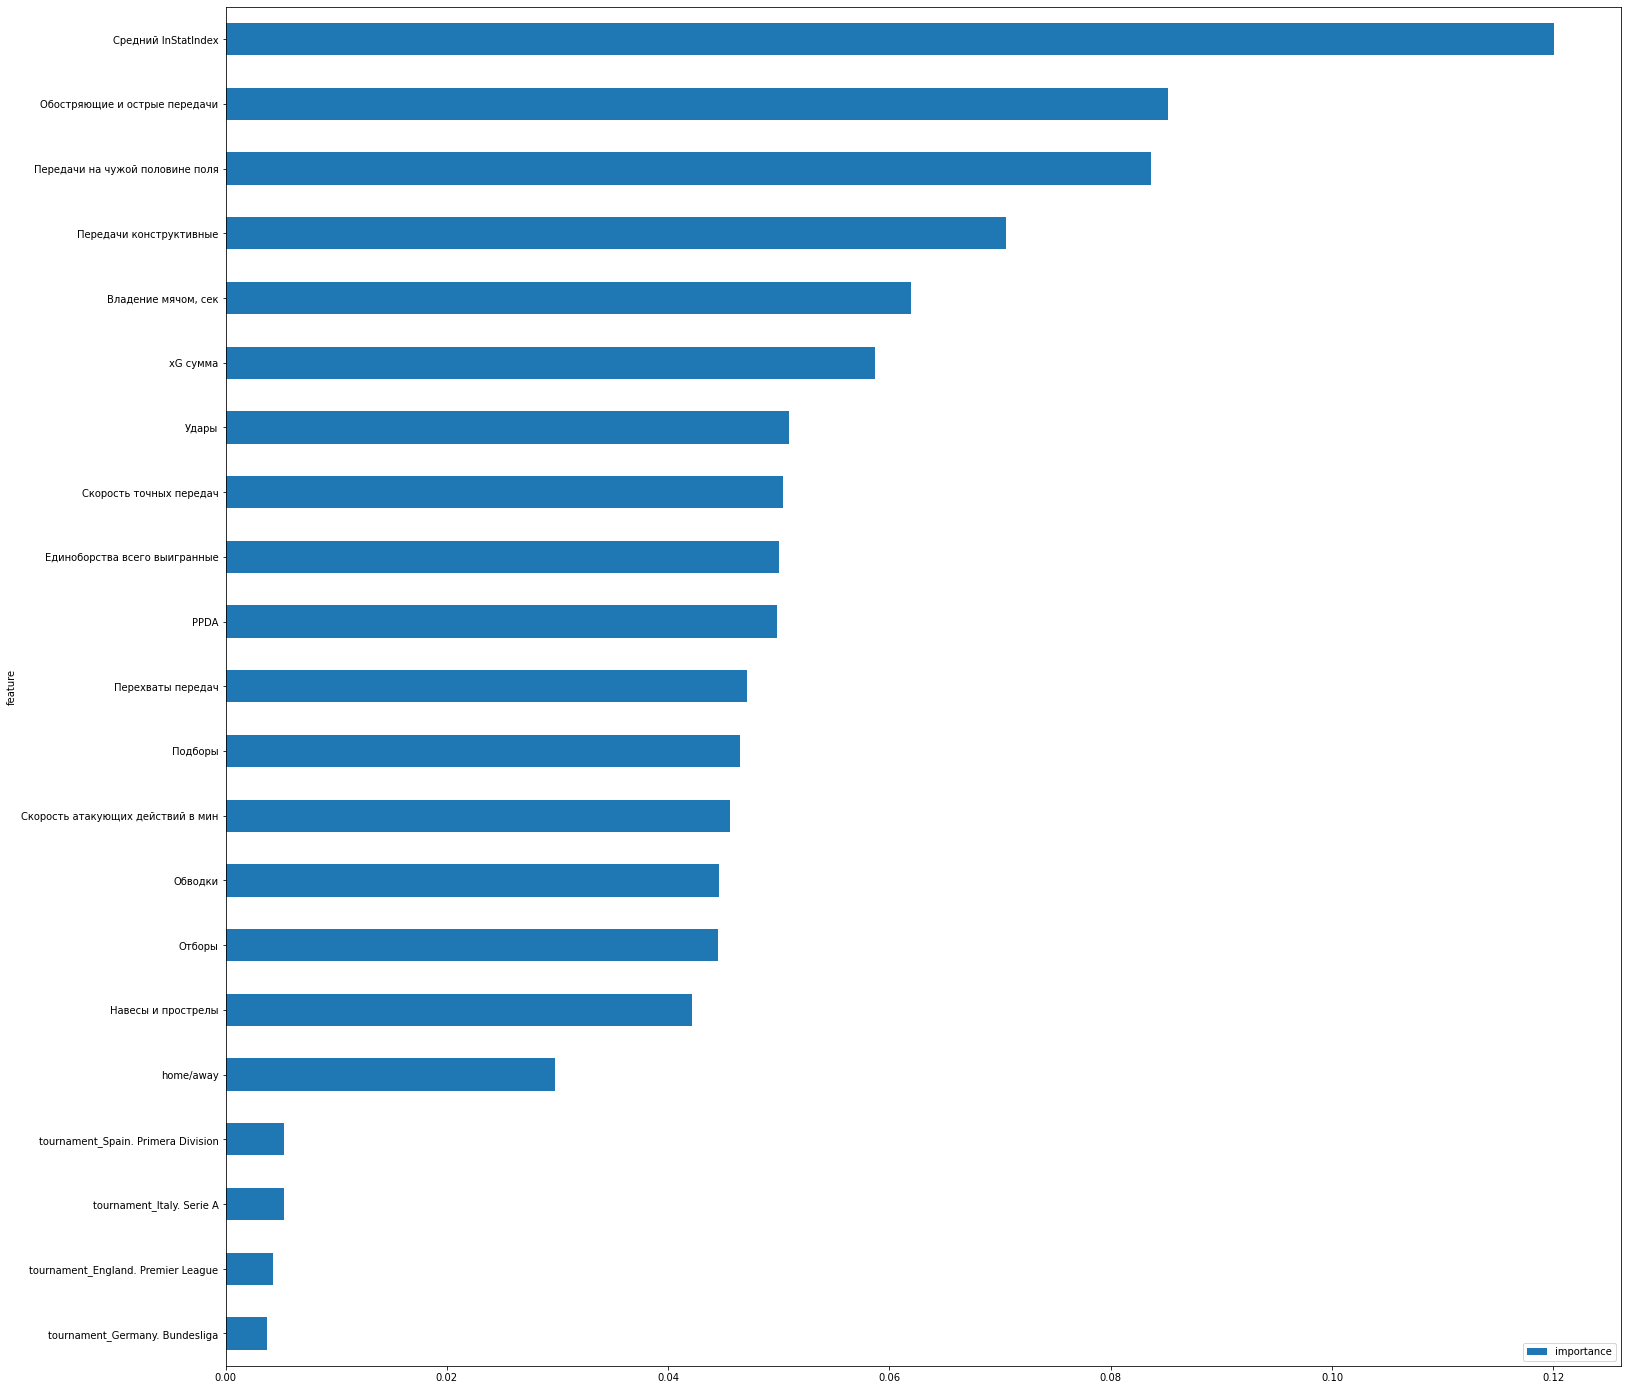

In [29]:
#Демонстрация наиболее важных признаков для классификатора RandomForestClassifier
clf = RandomForestClassifier(bootstrap=True, max_depth=16, max_features='sqrt', min_samples_leaf=7, min_samples_split=2, n_estimators=100)
clf.fit(features, labels) 

feat = pd.DataFrame()
feat['feature'] = features.columns
feat['importance'] = clf.feature_importances_
feat.sort_values(by=['importance'], ascending=True, inplace=True)
feat.set_index('feature', inplace=True)

feat.plot(kind='barh', figsize=(25, 25))